# Spectroscopy Tools for MUSE

Simon Conseil, *Centre de Recherche Astrophysique de Lyon (CRAL, CNRS, France)*

For the *Spectroscopy Tools in Python* workshop @STScI, 20 April 2017


# MPDAF, the MUSE Python Data Analysis Framework

Open source Python package, developped for the MUSE consortium, first public release in 07/2016.

- http://mpdaf.readthedocs.io/
- https://git-cral.univ-lyon1.fr/MUSE/mpdaf
    
MUSE:

- Second generation instrument at VLT
- Integral-field spectrograph, visible wavelength range
- ESO pipeline (CPL)
- Release of data and tools: http://muse-vlt.eu/science/

Data reduction and analysis:

- MUSE-specific data (raw data, pixel tables, etc.), 
- Spectra, images and data cubes
- Sources detection

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
from lineid_plot import plot_line_ids

# Astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

# MPDAF
from mpdaf.obj import Cube, Image, Spectrum
from mpdaf.sdetect import get_emlines
from mpdaf import log
log.clear_loggers()
log.setup_logging(stream=sys.stdout)

## Workflow : load data cube, extract images or spectra

### Using the HDFS public data cube: http://muse-vlt.eu/science/hdfs-v1-0/

27 hours integration in the *Hubble Deep Field South*, obtained during the commissioning period.

In [2]:
cube = Cube('../HDFS/dataproducts/HDFS-DataProducts-v1.0/DATACUBE_HDFS_v1p0.fits')
cube.info()

[INFO] 3641 x 331 x 326 Cube (../HDFS/dataproducts/HDFS-DataProducts-v1.0/DATACUBE_HDFS_v1p0.fits)


[INFO] .data(3641 x 331 x 326) (1e-20 erg / (Angstrom cm2 s)), .var(3641 x 331 x 326)
[INFO] center:(-60:33:49.0427,22:32:55.53) size:(66.139",65.126") step:(0.200",0.200") rot:0.1 deg frame:ICRS
[INFO] wavelength: min:4750.00 max:9300.00 step:1.25 Angstrom


In [3]:
cube

<Cube(shape=(3641, 331, 326), unit='1e-20 erg / (Angstrom cm2 s)', dtype='float64')>

In [4]:
cube.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 338.23143170700001  -60.563678379400002  
CRPIX : 163.0  165.0  
CD1_1 CD1_2  : -5.5492256836383998e-05  -9.6896317595166001e-08  
CD2_1 CD2_2  : -1.8970394399001999e-07  5.5504289755891897e-05  
NAXIS : 326  331  3641

In [5]:
cube.wave

WCS Keywords

Number of WCS axes: 1
CTYPE : 'LINEAR'  
CRVAL : 4750.0  
CRPIX : 1.0  
CD1_1  : 1.25  
NAXIS : 326  331  3641

In [6]:
cube.get_step(unit_wave=u.angstrom, unit_wcs=u.arcsec)

array([ 1.25      ,  0.19981575,  0.19977329])

In [7]:
cube.wave.coord(unit=u.angstrom)

array([ 4750.  ,  4751.25,  4752.5 , ...,  9297.5 ,  9298.75,  9300.  ])

In [8]:
# With HST images too
hst = Image('../HDFS/HST/f606_comb.fits')
hst

<Image(shape=(4600, 4096), unit='', dtype='None')>

In [9]:
# MUSE white-light image
img = cube.mean(axis=0)

In [10]:
# Get HST image with the same orientation, position, resolution and size
hstcropped = hst.align_with_image(img)

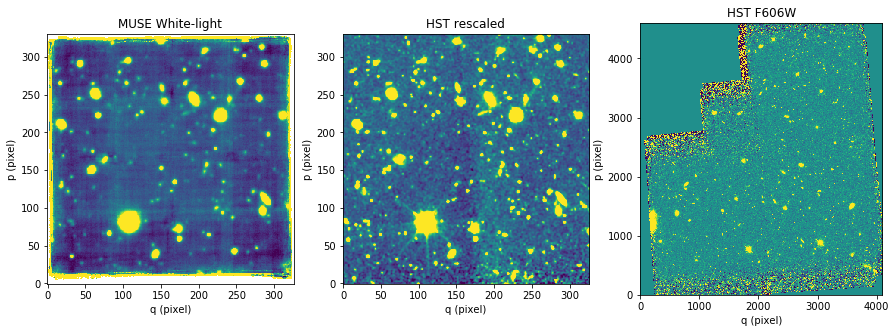

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
img.plot(ax=ax1, zscale=True, title='MUSE White-light')
hstcropped.plot(ax=ax2, zscale=True, title='HST rescaled')
hst.plot(ax=ax3, zscale=True, title='HST F606W')

### Example - Object #20 (from http://data.muse-vlt.eu/HDFS/Web/)

In [12]:
z = 0.4275
coord = SkyCoord('22:32:57.90 -60:33:49.12', unit=(u.hourangle, u.deg), frame='fk5')

lmin, lmax = cube.wave.get_range(unit=u.angstrom)
lmin, lmax

(4750.0, 9300.0)

In [13]:
lines = get_emlines(z=z, table=True, lbrange=(lmin, lmax))
lines.convert_bytestring_to_unicode()

main_lines = ('OII3726', 'OII3729', 'HBETA', 'OIII4959', 'OIII5007')

lines = lines[np.logical_or.reduce([lines['LINE'] == l for l in main_lines])]
lines

LINE,LBDA_OBS,LBDA_LOW,LBDA_UP,TYPE,DOUBLET
str20,float32,float32,float32,str2,float32
OII3726,5320.42,5306.02,5334.57,em,5321.01
OII3729,5324.4,5308.87,5337.42,em,5321.01
HBETA,6941.48,6924.8,6953.35,em,0.0
OIII4959,7080.83,7064.7,7093.25,em,0.0
OIII5007,7149.26,7133.22,7161.77,em,0.0


### Extract spectrum with circular aperture, plot lines

[INFO] 100 spaxels used


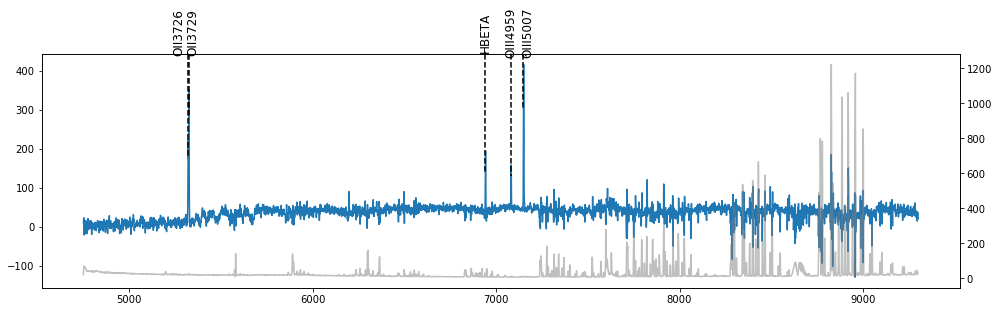

In [14]:
fig = plt.figure(figsize=(15,5))
center = (coord.dec.value, coord.ra.value)
spec = cube.aperture(center=center, radius=1)
plot_line_ids(spec.wave.coord(), spec.data, lines['LBDA_OBS'], lines['LINE'], fig=fig)
plt.twinx()
plt.plot(spec.wave.coord(), spec.var, color='gray', alpha=0.5)

### Narrow-band images

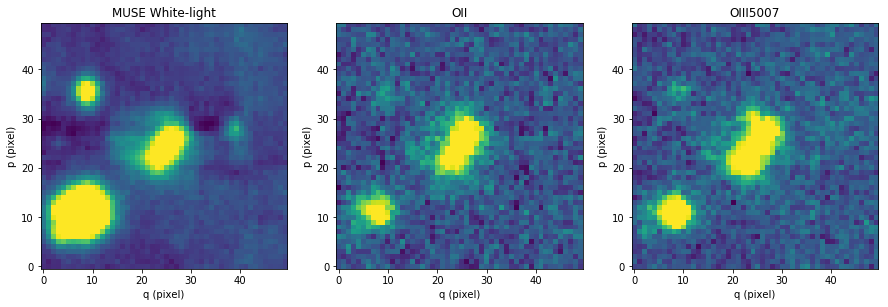

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
img.subimage(center, size=10).plot(ax=ax1, zscale=True, title='MUSE White-light')
nbOII = cube.subcube(center, size=10, lbda=(5322-5, 5322+5)).mean(axis=0)
nbOII.plot(ax=ax2, zscale=True, title='OII')
nbOIII = cube.subcube(center, size=10, lbda=(7149-5, 7149+5)).mean(axis=0)
nbOIII.plot(ax=ax3, zscale=True, title='OIII5007')

### Continuum estimation, fit lines

[INFO] Gaussian center = 6942.47 (error:0.070256)
[INFO] Gaussian integrated flux = 441.315 (error:23.8371)
[INFO] Gaussian peak value = 161.297 (error:0.780317)
[INFO] Gaussian fwhm = 2.57034 (error:0.151269)
[INFO] Gaussian continuum = -2.80495


/home/conseil/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/home/conseil/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


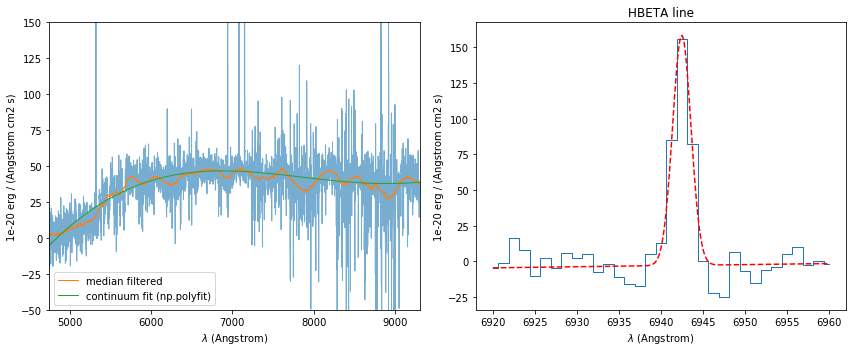

In [16]:
plt.figure(figsize=(12, 5), tight_layout=True)

plt.subplot(121)
cont = spec.poly_spec(5)
spec.plot(alpha=0.6)
spec.median_filter(151).plot(lw=2, label='median filtered')
cont.plot(lw=2, label='continuum fit (np.polyfit)')
plt.ylim((-50, 150))
plt.legend()

# Arithmetic on MPDAF objects
spec2 = spec - cont
spec2 -= spec2.median_filter(51)

plt.subplot(122)
spec2.plot(lmin=6920, lmax=6960, unit=u.angstrom, title = 'HBETA line')
fit = spec2.gauss_fit(lmin=6920, lmax=6960, unit=u.angstrom, plot=True)
fit.print_param()

## Spectrum, Image and Cube format

- Store data, variance and (shared) mask
- Variance propagation
- Astropy units, arithmetic

→ Similar to `NDData`, specialized for 1D/2D/3D with a common behavior, with FITS I/O and lazy loading (memmap used to load only a part of a cube).

### Masking, interpolation, resampling, convolution, fitting.

### More in `mpdaf.sdetect`: Source detection, use of masks, spectrum extraction, basic redshifting

### + Save all information on a source (cube, images, spectra, metadata, etc.) in a "Source" FITS file